# 🎉 VAE-Simplified: Decoder-Only with One Time Step

In this notebook, **we'll explore a "VAE-like" model** that omits the encoder altogether and relies on a **single-step fixed corruption process** to act as our "inference." We'll see how the **original ELBO** simplifies into a **noise-prediction objective**, much like in diffusion models — but with just one denoising step.

---

## 🚀 Motivation

Standard VAEs learn both:

1. An **encoder** $ q_\phi(z \mid x) $ that transforms data $x$ into latent code $z$
2. A **decoder** $ p_\theta(x \mid z) $ that reconstructs $x$ from $z$

However, here we **remove** the learned encoder and instead **fix** a one-step noising process that acts as our "latent." In other words:

1. We **corrupt** the input $ x_0 $ into $ x_1 $ by adding Gaussian noise:
   $$
   x_1 = \sqrt{\alpha} \, x_0 \;+\; \sqrt{1 - \alpha}\,\epsilon, 
   \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
   $$

2. We **learn** a decoder $ p_\theta(x_0 \mid x_1) $ that tries to reconstruct $ x_0 $ from $ x_1 $.

This single-step noising is analogous to a **one-step diffusion** but can also be viewed under a **variational** lens — the difference being that our "encoder" is **fixed** by design, rather than learned.

---

## 🔧 Model Setup

1. **Forward / Corruption Process** (fixed):
   $$
   q(x_1 \mid x_0) = \mathcal{N}\!\bigl(x_1; \sqrt{\alpha} \, x_0,\,(1 - \alpha)\,\mathbf{I}\bigr)
   $$
   - We treat $ x_1 $ as a noisy "latent" version of $ x_0 $.

2. **Prior on $ x_1 $**:
   $$
   p(x_1) = \mathcal{N}(x_1; 0, \mathbf{I})
   $$
   (Optionally, we match $ x_1 $ to a standard Gaussian prior, though some setups skip this term.)

3. **Decoder (Denoiser)**:
   $$
   p_\theta(x_0 \mid x_1) 
   $$
   We learn this distribution, typically parameterized by a neural network.  
   - Equivalently, we might learn $ \epsilon_\theta(x_1) $ to predict the noise that was added.

---

## 🧮 ELBO Derivation

### 1. Evidence Lower Bound

We start with the **ELBO** on the data distribution $ p_\theta(x_0) $. We introduce $ x_1 $ as a latent:

$$
\log p_\theta(x_0) 
= \log \int p_\theta(x_0, x_1) \, dx_1
= \log \int p(x_1)\,p_\theta(x_0 \mid x_1)\,dx_1
$$

But we can’t directly evaluate this integral. So we use our **fixed** $ q(x_1 \mid x_0) $ (the noising process) and rewrite:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \frac{p(x_1)\,p_\theta(x_0 \mid x_1)}{q(x_1 \mid x_0)}
\Bigr]
$$

Applying **Jensen’s inequality**:

$$
\log p_\theta(x_0) \;\ge\;
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p(x_1) + \log p_\theta(x_0 \mid x_1) \;-\; \log q(x_1 \mid x_0)
\Bigr]
\;=\; \mathcal{L}_{\text{ELBO}}
$$

Hence,

$$
\mathcal{L}_{\text{ELBO}} 
= 
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p_\theta(x_0 \mid x_1)
  + \log p(x_1)
  - \log q(x_1 \mid x_0)
\Bigr].
$$

---

### 2. 🔍 Breaking Down the ELBO Terms (with Detailed Derivations)

Recall our ELBO:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_1 \mid x_0)}\left[
\log p_\theta(x_0 \mid x_1)
\right]
- D_{\text{KL}}\left(q(x_1 \mid x_0) \,\|\, p(x_1)\right)
$$

We analyze each term in detail.

---

#### 🔹 1. Reconstruction Term:  
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
$$

Assume the decoder is Gaussian:
$$
p_\theta(x_0 \mid x_1) = \mathcal{N}(x_0; \mu_\theta(x_1), \sigma^2 I)
$$

Then:
$$
\log p_\theta(x_0 \mid x_1)
= -\frac{1}{2 \sigma^2} \|x_0 - \mu_\theta(x_1)\|^2 + \text{const}
$$

Therefore, maximizing the log-likelihood is equivalent to **minimizing MSE**:
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
\;\Leftrightarrow\;
- \mathbb{E}_{q(x_1 \mid x_0)}\left[ \|x_0 - \mu_\theta(x_1)\|^2 \right]
$$

This is the traditional **reconstruction loss**, but it still depends on predicting the clean image $ x_0 $.

---

#### 🔹 2. KL Term (Prior Matching):  
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, p(x_1))
$$

Assume:
- $ q(x_1 \mid x_0) = \mathcal{N}(x_1; \sqrt{\alpha} x_0, (1 - \alpha) I) $
- $ p(x_1) = \mathcal{N}(0, I) $

Then we can use the KL formula for two Gaussians:
$$
D_{\text{KL}}(\mathcal{N}(\mu_1, \Sigma_1) \,\|\, \mathcal{N}(\mu_2, \Sigma_2)) = 
\frac{1}{2} \left[
\text{tr}(\Sigma_2^{-1} \Sigma_1)
+ (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1)
- k + \log \left( \frac{\det \Sigma_2}{\det \Sigma_1} \right)
\right]
$$

Plug in:
- $ \mu_1 = \sqrt{\alpha} x_0 $, $ \Sigma_1 = (1 - \alpha) I $
- $ \mu_2 = 0 $, $ \Sigma_2 = I $

We get:
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, \mathcal{N}(0, I)) =
\frac{1}{2} \left[
\frac{d (1 - \alpha)}{1} + \frac{\|\sqrt{\alpha} x_0\|^2}{1}
- d + \log\left( \frac{1}{(1 - \alpha)^d} \right)
\right]
$$

This evaluates to a **closed-form scalar**, which depends on $ x_0 $, but **does not require learning** — so it can be ignored or precomputed.

---

## 🔑 Connection to Noise Prediction

Instead of predicting $ x_0 $ from $ x_1 $, we **predict the noise $ \epsilon $** that was added during the forward process:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon,
\quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$

Rewriting:
$$
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
\quad \Rightarrow \quad
x_0 = \frac{x_1 - \sqrt{1 - \alpha} \epsilon}{\sqrt{\alpha}}
$$

Now suppose we train a model $ \epsilon_\theta(x_1) $ to **predict this noise**.

Substitute the predicted $ \hat{\epsilon}_\theta $ back into the expression for $ \mu_\theta(x_1) $:

$$
\hat{x}_0 = \frac{1}{\sqrt{\alpha}} \left( x_1 - \sqrt{1 - \alpha} \, \hat{\epsilon}_\theta(x_1) \right)
$$

So predicting $ \epsilon $ is **equivalent to** predicting $ x_0 $, but in a different form.

---

### 🎯 Why This Works

We assume the **true posterior** is:

$$
q(x_1 \mid x_0) = \mathcal{N}(\sqrt{\alpha} x_0, (1 - \alpha) I)
$$

If we know $ x_1 $, the most informative thing to do is to **recover $ x_0 $** — and we can do this by first predicting $ \epsilon $, because:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon \;\Rightarrow\;
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
$$

So predicting $ \epsilon $ is as good as predicting $ x_0 $, but it's **easier** and has **less variance**.

---

### ✅ Final Noise Prediction Objective

We define:

$$
\mathcal{L}_{\text{simple}} =
\mathbb{E}_{x_0 \sim \text{data}, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_1) \right\|^2
\right],
\quad \text{where } x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon
$$

This objective is **equivalent to maximizing the original ELBO**, under the assumptions that:
- $ p_\theta(x_0 \mid x_1) $ is Gaussian with fixed variance
- $ p(x_1) $ is Gaussian prior
- We're ignoring the constant KL term

So instead of learning to reconstruct $ x_0 $, we **learn to denoise the corruption** — which is a **simplified variational training objective**.

---

## ✅ Summary

- **We fix a one-step Gaussian corruption** to transform $ x_0 $ into $ x_1$. 
- **We learn a single-step decoder** $ p_\theta(x_0 \mid x_1) $ (or noise predictor $\epsilon_\theta$).
- **Our ELBO** breaks down into a reconstruction term and a KL term that aligns $ x_1 $ with a prior. 
- By parameterizing the decoder to predict **noise** rather than $ x_0$, the resulting **loss** is essentially an **MSE** between true noise $\epsilon$ and $\epsilon_\theta(x_1)$.

This **mirrors** the key simplification in standard DDPMs, but restricted to **just one step**. It’s not a “VAE” in the classic sense (no learned encoder), but it’s still a **variational model** with **fixed inference** and **learned generative** processes.

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)


# 🚀 Extended Explanation of the Code: U-Net for Single-Step Denoising

Below is a **supplement** to the "VAE-Simplified" discussion. It explains the **U-Net architecture** used in this notebook as a **noise predictor** for the single-step corruption model. U-Net is used in diffusion models because its skip connections allow the model to preserve fine-grained spatial details from the input noisy image while also capturing global context through the encoder-decoder structure, which is essential for accurately predicting the noise pattern that needs to be removed at each denoising step.

---

## 1. **UNet Architecture**

For the task of predicting noise from a corrupted image $x_1$, we employ a U-Net architecture built with standard convolutional blocks for simplicity and clarity.

1.  **UNet Core Structure**:
    *   **Encoder Path**: Gradually downsamples the input image, increasing channel depth. This path captures contextual information at multiple scales. It consists of `EncoderBlock` modules.
        *   Each `EncoderBlock` contains several `ResBlock` layers (simple residual blocks with skip connections) followed by a `DownBlock` layer (stride-2 convolution to reduce spatial dimensions).
    *   **Bottleneck**: A middle section with `ResBlock` layers that processes features at the lowest spatial resolution, providing a large receptive field.
    *   **Decoder Path**: Gradually upsamples the features, decreasing channel depth, to reconstruct the desired output (predicted noise). This path uses `DecoderBlock` modules.
        *   Each `DecoderBlock` starts with an `UpBlock` layer (bilinear upsampling + convolution), concatenates features from the corresponding encoder block (skip connection), and processes them through `ResBlock` layers.
    *   **Skip Connections**: These connections pass feature maps from encoder blocks directly to corresponding decoder blocks. This helps recover fine details lost during downsampling and improves gradient flow.

2.  **Simple Building Blocks**:
    *   **ConvBlock**: Basic building block with Conv2d + BatchNorm + SiLU activation.
    *   **ResBlock**: Simple residual block with two ConvBlocks and a skip connection.
    *   **DownBlock**: Downsampling using stride-2 convolution.
    *   **UpBlock**: Upsampling using bilinear interpolation followed by convolution.

3.  **U-Net in `02.vae-without-encoder.ipynb`**:
    *   The `Unet` class implements this straightforward architecture.
    *   Crucially, for this single-step model, the U-Net **does not use time embeddings**. The corruption is fixed (a single $\alpha$ value), so the network doesn't need to adapt to different noise levels. Its task is to denoise $x_1$ which always has similar noise characteristics defined by the chosen $\alpha$.

---

## 2. **U-Net as a Noise Predictor in the Single-Step Model**

In this notebook's "VAE-Simplified" setup:
1.  An original image $x_0$ is corrupted to $x_1$ using a fixed process:
    $x_1 = \sqrt{\alpha} \, x_0 + \sqrt{1 - \alpha}\,\epsilon$, where $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.
2.  The U-Net, denoted $\epsilon_\theta(x_1)$, is trained to predict the noise $\epsilon$ that was added to $x_0$ to produce $x_1$.
    *   **Input**: The noisy image $x_1$.
    *   **Output**: The predicted noise $\hat{\epsilon} = \epsilon_\theta(x_1)$.

The U-Net's encoder-decoder structure with skip connections is well-suited for this image-to-image task, allowing it to capture multi-scale features of the noisy input to accurately estimate the noise pattern.

---

## 3. **Training and Sampling**

1.  **Training**:
    *   The model is trained by minimizing the Mean Squared Error (MSE) between the true noise $\epsilon$ and the predicted noise $\hat{\epsilon}$:
        $\mathcal{L} = \| \epsilon - \epsilon_\theta(x_1) \|^2$.
    *   For each training step:
        *   Take a batch of clean images $x_0$.
        *   Generate noise $\epsilon$.
        *   Compute $x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon$.
        *   Pass $x_1$ through the U-Net to get $\hat{\epsilon}$.
        *   Compute the MSE loss and update the U-Net's parameters $\theta$.

2.  **Sampling (Generating New Images)**:
    *   To generate a new image $\hat{x}_0$:
        1.  First, we need a sample of $x_1$. The code estimates the mean and standard deviation of $x_1$ from the training data (corrupted by the fixed $\alpha$) and then samples `x1_gen = x1_mean + x1_std * eps_gen_for_x1`, where `eps_gen_for_x1` is random Gaussian noise.
        2.  Pass this $x_1^{gen}$ through the trained U-Net: $\hat{\epsilon}_{gen} = \epsilon_\theta(x_1^{gen})$.
        3.  Reconstruct an estimate of the clean image $\hat{x}_0$ using the predicted noise:
            $\hat{x}_0 = \frac{1}{\sqrt{\alpha}} (x_1^{gen} - \sqrt{1 - \alpha} \, \hat{\epsilon}_{gen})$.
        4.  The result $\hat{x}_0$ is then clamped and normalized for visualization.

---

## 4. **Conclusion for Single-Step Denoising**

*   The simple U-Net architecture provides a capable yet straightforward approach for the noise prediction task in this single-step generative model.
*   This setup serves as an excellent introduction to understanding more complex diffusion models. It demonstrates the core concept of learning a denoiser without the complexity of multi-step processes.
*   However, as observed, single-step denoising with a fixed corruption level has inherent limitations. The quality of generated images may not be high, and $x_1$ isn't truly a standard Gaussian distribution unless $\alpha$ is very small (which would erase most of the signal from $x_0$). This fundamental trade-off motivates the multi-step approach seen in full diffusion models.

You now have a clear understanding of how the U-Net architecture is employed and trained within the context of the single-step "VAE-without-encoder" model.

## References

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm


###############################################################################
# 1) Simple Model Components
###############################################################################
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class ResBlock(nn.Module):
    """Simple residual block with regular convolutions"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )
        self.act = nn.SiLU()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.act(x)


class DownBlock(nn.Module):
    """Downsample block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class UpBlock(nn.Module):
    """Upsample block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


class EncoderBlock(nn.Module):
    """Encoder block with residual layers and downsampling"""
    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        super().__init__()
        
        # Residual blocks at current resolution
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels) for _ in range(num_res_blocks)
        ])
        
        # Downsample
        self.downsample = DownBlock(in_channels, out_channels)

    def forward(self, x):
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Save skip connection before downsampling
        x_skip = x
        
        # Downsample
        x = self.downsample(x)
        
        return x, x_skip


class DecoderBlock(nn.Module):
    """Decoder block with upsampling and residual layers"""
    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        super().__init__()
        
        # Upsample
        self.upsample = UpBlock(in_channels, out_channels)
        
        # Residual blocks after concatenation (out_channels + skip_channels)
        self.res_blocks = nn.ModuleList([
            ResBlock(out_channels * 2) for _ in range(num_res_blocks)
        ])
        
        # Final conv to reduce channels
        self.final_conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, x_skip):
        # Upsample
        x = self.upsample(x)
        
        # Handle size mismatch
        if x.shape[2] > x_skip.shape[2] or x.shape[3] > x_skip.shape[3]:
            target_h, target_w = x_skip.shape[2], x_skip.shape[3]
            x = x[:, :, :target_h, :target_w]
        
        # Concatenate with skip connection (this happens in the channel dimension)
        x = torch.cat([x, x_skip], dim=1)
        
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Final conv
        x = self.final_conv(x)
        
        return x


class Unet(nn.Module):
    """Simple UNet with regular convolutions"""
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        base_dim=64,
        dim_mults=(1, 2, 4),
        num_res_blocks_encoder=2,
        num_res_blocks_decoder=2,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        
        # Initial conv
        self.init_conv = ConvBlock(in_channels, base_dim)

        # Build channel dimensions
        dims = [base_dim]
        for mult in dim_mults:
            dims.append(base_dim * mult)

        # Encoder blocks
        self.enc_blocks = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.enc_blocks.append(
                EncoderBlock(dims[i], dims[i + 1], num_res_blocks_encoder)
            )

        # Middle block
        mid_dim = dims[-1]
        self.mid_blocks = nn.ModuleList([
            ResBlock(mid_dim) for _ in range(num_res_blocks_mid)
        ])

        # Decoder blocks
        self.dec_blocks = nn.ModuleList()
        for i in range(len(dims) - 1, 0, -1):
            self.dec_blocks.append(
                DecoderBlock(dims[i], dims[i - 1], num_res_blocks_decoder)
            )

        # Final conv
        self.final_conv = nn.Conv2d(base_dim, out_channels, 1)

    def forward(self, x):
        # Initial conv
        x = self.init_conv(x)

        # Encoder path
        skips = []
        for enc_block in self.enc_blocks:
            x, x_skip = enc_block(x)
            skips.append(x_skip)

        # Middle blocks
        for mid_block in self.mid_blocks:
            x = mid_block(x)

        # Decoder path
        skips.reverse()
        for dec_block, x_skip in zip(self.dec_blocks, skips):
            x = dec_block(x, x_skip)

        # Final conv
        return self.final_conv(x)


class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dims=(32, 64, 32)):
        super().__init__()
        layers = []
        current_channels = in_channels
        for h_dim in hidden_dims:
            # Using kernel_size=3 and padding=1 to maintain spatial dimensions
            layers.append(ConvBlock(current_channels, h_dim, kernel_size=3, padding=1))
            current_channels = h_dim
        # Final convolution to get to out_channels, also maintaining dimensions
        layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


###############################################################################
# 2) One-Step Loss
###############################################################################
def noise_predictor_loss(x0, model, alpha=0.9):
    eps = torch.randn_like(x0)
    x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps
    eps_hat = model(x1)
    loss = F.mse_loss(eps_hat, eps, reduction="sum")
    return loss, x1, eps, eps_hat


###############################################################################
# 3) Estimate x1 Stats
###############################################################################
def estimate_x1_stats(dataloader, alpha=0.9, device="cpu"):
    x1_list = []
    print("Estimating x1 statistics...")
    for x0, _ in tqdm(dataloader, desc="Estimating x1 stats", leave=False):
        x0 = x0.to(device)
        eps = torch.randn_like(x0)
        x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps
        x1_list.append(x1.cpu())

    x1_all = torch.cat(x1_list, dim=0)
    x1_mean = x1_all.mean(dim=0, keepdim=True)
    x1_std = x1_all.std(dim=0, keepdim=True)
    print("Finished estimating x1 statistics.")
    return x1_mean, x1_std


###############################################################################
# 4) Main Training + Sampling
###############################################################################
def run_noise_predictor(
    # General parameters
    model_type: str = "unet", # "unet" or "simple_cnn"
    alpha=0.9,
    epochs=20,
    batch_size=128,
    lr=1e-3,
    show_every=10,
    log_freq=50,
    n_samples=16,
    # Unet specific parameters
    base_dim=32,
    dim_mults=(1, 2, 4),
    num_res_blocks_encoder=2,
    num_res_blocks_decoder=2,
    num_res_blocks_mid=2,
    # SimpleCNN specific parameters
    simple_cnn_hidden_dims=(32, 64, 128, 64, 32),
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Selected model type: {model_type}")

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    train_data = datasets.MNIST(
        "./data", train=True, download=True, transform=transform
    )
    stat_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True if device.type == "cuda" else False,
    )
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True if device.type == "cuda" else False,
    )

    x1_mean_cpu, x1_std_cpu = estimate_x1_stats(stat_loader, alpha=alpha, device=device)

    if model_type == "unet":
        model = Unet(
            in_channels=1,
            out_channels=1,
            base_dim=base_dim,
            dim_mults=dim_mults,
            num_res_blocks_encoder=num_res_blocks_encoder,
            num_res_blocks_decoder=num_res_blocks_decoder,
            num_res_blocks_mid=num_res_blocks_mid,
        ).to(device)
    elif model_type == "simple_cnn":
        model = SimpleCNN(
            in_channels=1,
            out_channels=1,
            hidden_dims=simple_cnn_hidden_dims
        ).to(device)
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Choose 'unet' or 'simple_cnn'.")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters ({model_type.upper()}): {num_params:,}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss_sum = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for batch_idx, (x_batch, _) in progress_bar:
            x_batch = x_batch.to(device)
            loss, _, _, _ = noise_predictor_loss(x_batch, model, alpha=alpha)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss_sum += loss.item()
            
            if (batch_idx + 1) % log_freq == 0 or (batch_idx + 1) == len(train_loader):
                current_batch_loss_avg = loss.item() / x_batch.size(0)
                progress_bar.set_postfix(batch_loss=f'{current_batch_loss_avg:.4f}')
        
        avg_epoch_loss = epoch_loss_sum / len(train_loader.dataset)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % show_every == 0 or (epoch == epochs - 1):
            model.eval()
            with torch.no_grad():
                eps_gen_for_x1 = torch.randn(n_samples, 1, 28, 28, device=device)
                x1_mean = x1_mean_cpu.to(device)
                x1_std = x1_std_cpu.to(device)
                x1_gen = x1_mean + x1_std * eps_gen_for_x1

                eps_hat_gen = model(x1_gen)

                safe_alpha = max(alpha, 1e-6)
                x0_hat = (x1_gen - ((1 - safe_alpha) ** 0.5) * eps_hat_gen) / (
                    safe_alpha**0.5
                )
                x0_hat = x0_hat.clamp(-1.0, 1.0)
                x0_vis = (x0_hat + 1.0) / 2.0
                x0_vis = x0_vis.clamp(0.0, 1.0)

                grid = torchvision.utils.make_grid(x0_vis, nrow=int(math.sqrt(n_samples)), padding=2)
                fig_size_factor = max(4, int(math.sqrt(n_samples)) * 1.0)
                plt.figure(figsize=(fig_size_factor, fig_size_factor))
                plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
                plt.title(f"Generated Samples (Epoch {epoch+1}, Model: {model_type.upper()})")
                plt.axis("off")
                plt.show()

/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




--- Training SimpleCNN Model ---
Using device: cuda
Selected model type: simple_cnn
Estimating x1 statistics...


Finished estimating x1 statistics.
Trainable Parameters (SIMPLE_CNN): 149,377


Epoch 1/100: 100%|██████████| 59/59 [00:06<00:00,  8.97it/s, batch_loss=71.7975]

Epoch [1/100] - Avg Loss: 127.2459



Epoch 2/100: 100%|██████████| 59/59 [00:06<00:00,  9.77it/s, batch_loss=50.2667]

Epoch [2/100] - Avg Loss: 57.8605



Epoch 3/100: 100%|██████████| 59/59 [00:06<00:00,  9.14it/s, batch_loss=46.4838]

Epoch [3/100] - Avg Loss: 48.1955



Epoch 4/100: 100%|██████████| 59/59 [00:06<00:00,  9.38it/s, batch_loss=44.4747]

Epoch [4/100] - Avg Loss: 45.4224



Epoch 5/100: 100%|██████████| 59/59 [00:06<00:00,  9.45it/s, batch_loss=43.1169]

Epoch [5/100] - Avg Loss: 44.0041



Epoch 6/100: 100%|██████████| 59/59 [00:06<00:00,  9.35it/s, batch_loss=42.5640]

Epoch [6/100] - Avg Loss: 42.7847



Epoch 7/100: 100%|██████████| 59/59 [00:06<00:00,  9.16it/s, batch_loss=41.9407]

Epoch [7/100] - Avg Loss: 41.9601



Epoch 8/100: 100%|██████████| 59/59 [00:06<00:00,  9.18it/s, batch_loss=41.7762]

Epoch [8/100] - Avg Loss: 41.1147



Epoch 9/100: 100%|██████████| 59/59 [00:06<00:00,  9.35it/s, batch_loss=41.5499]

Epoch [9/100] - Avg Loss: 40.7840



Epoch 10/100: 100%|██████████| 59/59 [00:06<00:00,  9.13it/s, batch_loss=40.6293]


Epoch [10/100] - Avg Loss: 40.2881


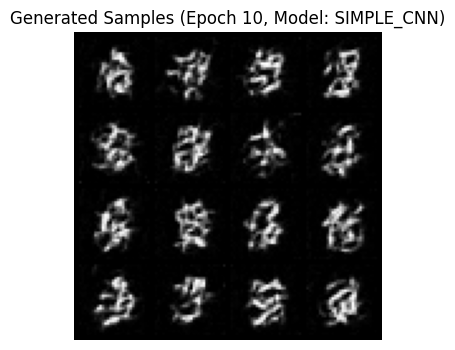

Epoch 11/100: 100%|██████████| 59/59 [00:06<00:00,  9.44it/s, batch_loss=39.1444]

Epoch [11/100] - Avg Loss: 39.7432



Epoch 12/100: 100%|██████████| 59/59 [00:06<00:00,  9.81it/s, batch_loss=38.2026]

Epoch [12/100] - Avg Loss: 39.5037



Epoch 13/100: 100%|██████████| 59/59 [00:06<00:00,  9.55it/s, batch_loss=39.4130]

Epoch [13/100] - Avg Loss: 39.1564



Epoch 14/100: 100%|██████████| 59/59 [00:06<00:00,  9.62it/s, batch_loss=38.1577]

Epoch [14/100] - Avg Loss: 38.7817



Epoch 15/100: 100%|██████████| 59/59 [00:06<00:00,  9.68it/s, batch_loss=38.1754]

Epoch [15/100] - Avg Loss: 38.4922



Epoch 16/100: 100%|██████████| 59/59 [00:06<00:00,  9.78it/s, batch_loss=37.7405]

Epoch [16/100] - Avg Loss: 38.4227



Epoch 17/100: 100%|██████████| 59/59 [00:05<00:00,  9.88it/s, batch_loss=38.4723]

Epoch [17/100] - Avg Loss: 37.9440



Epoch 18/100: 100%|██████████| 59/59 [00:06<00:00,  9.72it/s, batch_loss=37.0109]

Epoch [18/100] - Avg Loss: 37.9629



Epoch 19/100: 100%|██████████| 59/59 [00:06<00:00,  9.83it/s, batch_loss=38.1447]

Epoch [19/100] - Avg Loss: 37.8713



Epoch 20/100: 100%|██████████| 59/59 [00:05<00:00,  9.87it/s, batch_loss=36.7495]


Epoch [20/100] - Avg Loss: 37.5875


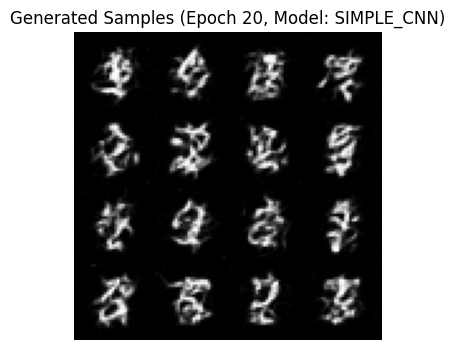

Epoch 21/100: 100%|██████████| 59/59 [00:05<00:00,  9.92it/s, batch_loss=35.9142]

Epoch [21/100] - Avg Loss: 37.4554



Epoch 22/100: 100%|██████████| 59/59 [00:06<00:00,  9.73it/s, batch_loss=36.6533]

Epoch [22/100] - Avg Loss: 37.3212



Epoch 23/100: 100%|██████████| 59/59 [00:06<00:00,  9.75it/s, batch_loss=37.0249]

Epoch [23/100] - Avg Loss: 37.1977



Epoch 24/100: 100%|██████████| 59/59 [00:06<00:00,  9.67it/s, batch_loss=37.4792]

Epoch [24/100] - Avg Loss: 37.1589



Epoch 25/100: 100%|██████████| 59/59 [00:06<00:00,  9.59it/s, batch_loss=37.2584]

Epoch [25/100] - Avg Loss: 37.2074



Epoch 26/100: 100%|██████████| 59/59 [00:06<00:00,  9.35it/s, batch_loss=37.3155]

Epoch [26/100] - Avg Loss: 36.8560



Epoch 27/100: 100%|██████████| 59/59 [00:06<00:00,  9.42it/s, batch_loss=36.6133]

Epoch [27/100] - Avg Loss: 36.8430



Epoch 28/100: 100%|██████████| 59/59 [00:05<00:00,  9.91it/s, batch_loss=36.4577]

Epoch [28/100] - Avg Loss: 36.7140



Epoch 29/100: 100%|██████████| 59/59 [00:06<00:00,  9.64it/s, batch_loss=36.8264]

Epoch [29/100] - Avg Loss: 36.8196



Epoch 30/100: 100%|██████████| 59/59 [00:05<00:00,  9.87it/s, batch_loss=36.6060]

Epoch [30/100] - Avg Loss: 36.5781


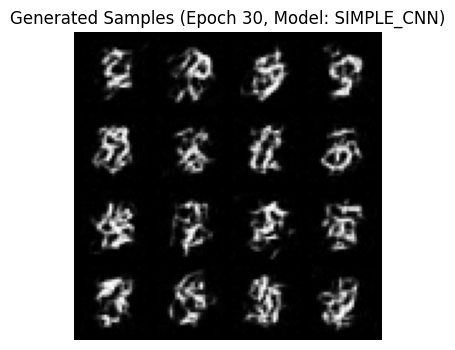

Epoch 31/100: 100%|██████████| 59/59 [00:05<00:00, 10.35it/s, batch_loss=36.3172]

Epoch [31/100] - Avg Loss: 36.6089



Epoch 32/100: 100%|██████████| 59/59 [00:05<00:00, 10.20it/s, batch_loss=36.2199]

Epoch [32/100] - Avg Loss: 36.4136



Epoch 33/100: 100%|██████████| 59/59 [00:06<00:00,  9.54it/s, batch_loss=36.1978]

Epoch [33/100] - Avg Loss: 36.4238



Epoch 34/100: 100%|██████████| 59/59 [00:06<00:00,  9.83it/s, batch_loss=35.8641]

Epoch [34/100] - Avg Loss: 36.3020



Epoch 35/100: 100%|██████████| 59/59 [00:06<00:00,  9.78it/s, batch_loss=36.5176]

Epoch [35/100] - Avg Loss: 36.2457



Epoch 36/100: 100%|██████████| 59/59 [00:05<00:00,  9.93it/s, batch_loss=36.1934]

Epoch [36/100] - Avg Loss: 36.2958



Epoch 37/100: 100%|██████████| 59/59 [00:06<00:00,  9.73it/s, batch_loss=36.6804]

Epoch [37/100] - Avg Loss: 36.1372



Epoch 38/100: 100%|██████████| 59/59 [00:06<00:00,  9.82it/s, batch_loss=37.4839]

Epoch [38/100] - Avg Loss: 36.2137



Epoch 39/100: 100%|██████████| 59/59 [00:06<00:00,  9.69it/s, batch_loss=35.7152]

Epoch [39/100] - Avg Loss: 36.0380



Epoch 40/100: 100%|██████████| 59/59 [00:06<00:00,  9.46it/s, batch_loss=35.4606]

Epoch [40/100] - Avg Loss: 36.1101


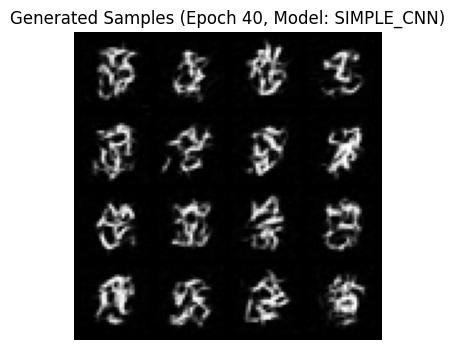

Epoch 41/100: 100%|██████████| 59/59 [00:05<00:00,  9.89it/s, batch_loss=36.3616]

Epoch [41/100] - Avg Loss: 36.1075



Epoch 42/100: 100%|██████████| 59/59 [00:06<00:00,  9.75it/s, batch_loss=35.5857]

Epoch [42/100] - Avg Loss: 36.0158



Epoch 43/100: 100%|██████████| 59/59 [00:05<00:00,  9.85it/s, batch_loss=35.8601]

Epoch [43/100] - Avg Loss: 35.8282



Epoch 44/100: 100%|██████████| 59/59 [00:06<00:00,  9.54it/s, batch_loss=35.3809]

Epoch [44/100] - Avg Loss: 35.7679



Epoch 45/100: 100%|██████████| 59/59 [00:06<00:00,  9.28it/s, batch_loss=36.1349]

Epoch [45/100] - Avg Loss: 35.8020



Epoch 46/100: 100%|██████████| 59/59 [00:06<00:00,  9.15it/s, batch_loss=35.9721]

Epoch [46/100] - Avg Loss: 35.9363



Epoch 47/100: 100%|██████████| 59/59 [00:06<00:00,  9.18it/s, batch_loss=36.1138]

Epoch [47/100] - Avg Loss: 35.9202



Epoch 48/100: 100%|██████████| 59/59 [00:06<00:00,  9.62it/s, batch_loss=35.8438]

Epoch [48/100] - Avg Loss: 35.7059



Epoch 49/100: 100%|██████████| 59/59 [00:06<00:00,  9.54it/s, batch_loss=35.0142]

Epoch [49/100] - Avg Loss: 35.7240



Epoch 50/100: 100%|██████████| 59/59 [00:05<00:00,  9.88it/s, batch_loss=35.4135]

Epoch [50/100] - Avg Loss: 35.7055


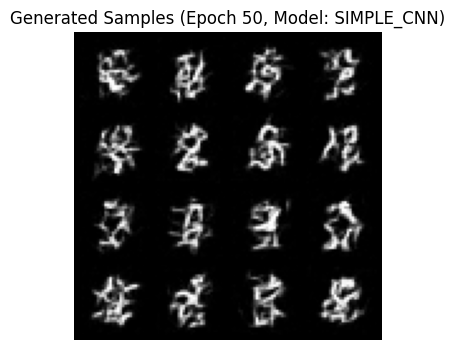

Epoch 51/100: 100%|██████████| 59/59 [00:05<00:00,  9.86it/s, batch_loss=35.6615]

Epoch [51/100] - Avg Loss: 35.6318



Epoch 52/100: 100%|██████████| 59/59 [00:06<00:00,  9.31it/s, batch_loss=35.8022]

Epoch [52/100] - Avg Loss: 35.6587



Epoch 53/100: 100%|██████████| 59/59 [00:06<00:00,  9.69it/s, batch_loss=35.1854]

Epoch [53/100] - Avg Loss: 35.3560



Epoch 54/100: 100%|██████████| 59/59 [00:06<00:00,  9.77it/s, batch_loss=35.3701]

Epoch [54/100] - Avg Loss: 35.5289



Epoch 55/100: 100%|██████████| 59/59 [00:06<00:00,  9.49it/s, batch_loss=35.4128]

Epoch [55/100] - Avg Loss: 35.4340



Epoch 56/100: 100%|██████████| 59/59 [00:06<00:00,  9.67it/s, batch_loss=35.0459]

Epoch [56/100] - Avg Loss: 35.5711



Epoch 57/100: 100%|██████████| 59/59 [00:06<00:00,  9.58it/s, batch_loss=34.4934]

Epoch [57/100] - Avg Loss: 35.4416



Epoch 58/100: 100%|██████████| 59/59 [00:06<00:00,  9.15it/s, batch_loss=35.8287]

Epoch [58/100] - Avg Loss: 35.3352



Epoch 59/100: 100%|██████████| 59/59 [00:06<00:00,  9.68it/s, batch_loss=35.0991]

Epoch [59/100] - Avg Loss: 35.6219



Epoch 60/100: 100%|██████████| 59/59 [00:06<00:00,  9.50it/s, batch_loss=35.3090]

Epoch [60/100] - Avg Loss: 35.3709


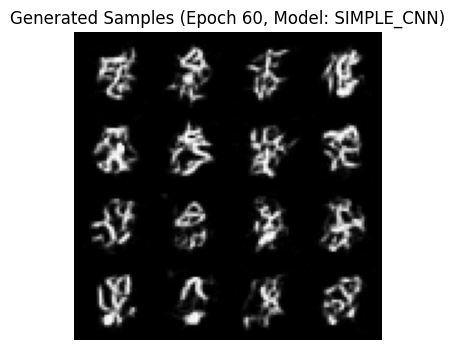

Epoch 61/100: 100%|██████████| 59/59 [00:06<00:00,  9.30it/s, batch_loss=34.9428]

Epoch [61/100] - Avg Loss: 35.3856



Epoch 62/100: 100%|██████████| 59/59 [00:05<00:00,  9.84it/s, batch_loss=35.0745]

Epoch [62/100] - Avg Loss: 35.2973



Epoch 63/100: 100%|██████████| 59/59 [00:06<00:00,  9.69it/s, batch_loss=35.9382]

Epoch [63/100] - Avg Loss: 35.2515



Epoch 64/100: 100%|██████████| 59/59 [00:06<00:00,  9.42it/s, batch_loss=35.6551]

Epoch [64/100] - Avg Loss: 35.5010



Epoch 65/100: 100%|██████████| 59/59 [00:06<00:00,  9.32it/s, batch_loss=34.7048]

Epoch [65/100] - Avg Loss: 35.1255



Epoch 66/100: 100%|██████████| 59/59 [00:06<00:00,  9.49it/s, batch_loss=35.5486]

Epoch [66/100] - Avg Loss: 35.1853



Epoch 67/100: 100%|██████████| 59/59 [00:06<00:00,  9.74it/s, batch_loss=34.3757]

Epoch [67/100] - Avg Loss: 35.2519



Epoch 68/100: 100%|██████████| 59/59 [00:06<00:00,  9.68it/s, batch_loss=34.6328]

Epoch [68/100] - Avg Loss: 35.1381



Epoch 69/100: 100%|██████████| 59/59 [00:06<00:00,  9.31it/s, batch_loss=35.1030]

Epoch [69/100] - Avg Loss: 35.1826



Epoch 70/100: 100%|██████████| 59/59 [00:06<00:00,  9.28it/s, batch_loss=34.9834]

Epoch [70/100] - Avg Loss: 35.1470


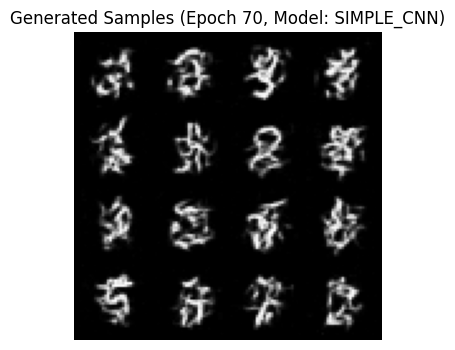

Epoch 71/100: 100%|██████████| 59/59 [00:06<00:00,  9.39it/s, batch_loss=34.8391]

Epoch [71/100] - Avg Loss: 35.1790



Epoch 72/100: 100%|██████████| 59/59 [00:06<00:00,  9.32it/s, batch_loss=35.0540]

Epoch [72/100] - Avg Loss: 35.1015



Epoch 73/100: 100%|██████████| 59/59 [00:06<00:00,  9.72it/s, batch_loss=34.4899]

Epoch [73/100] - Avg Loss: 35.1607



Epoch 74/100: 100%|██████████| 59/59 [00:06<00:00,  9.43it/s, batch_loss=36.0214]

Epoch [74/100] - Avg Loss: 35.0174



Epoch 75/100: 100%|██████████| 59/59 [00:06<00:00,  9.49it/s, batch_loss=35.1860]

Epoch [75/100] - Avg Loss: 35.0275



Epoch 76/100: 100%|██████████| 59/59 [00:06<00:00,  9.82it/s, batch_loss=35.9630]

Epoch [76/100] - Avg Loss: 34.8950



Epoch 77/100: 100%|██████████| 59/59 [00:06<00:00,  9.48it/s, batch_loss=34.3650]

Epoch [77/100] - Avg Loss: 35.1576



Epoch 78/100: 100%|██████████| 59/59 [00:06<00:00,  9.78it/s, batch_loss=35.2527]

Epoch [78/100] - Avg Loss: 35.0348



Epoch 79/100: 100%|██████████| 59/59 [00:06<00:00,  9.36it/s, batch_loss=35.5166]

Epoch [79/100] - Avg Loss: 34.9558



Epoch 80/100: 100%|██████████| 59/59 [00:06<00:00,  9.20it/s, batch_loss=34.5322]

Epoch [80/100] - Avg Loss: 35.0695


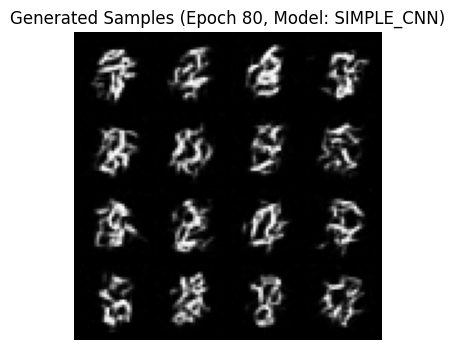

Epoch 81/100: 100%|██████████| 59/59 [00:06<00:00,  9.24it/s, batch_loss=35.1684]

Epoch [81/100] - Avg Loss: 34.8456



Epoch 82/100: 100%|██████████| 59/59 [00:06<00:00,  9.65it/s, batch_loss=35.1606]

Epoch [82/100] - Avg Loss: 35.1123



Epoch 83/100: 100%|██████████| 59/59 [00:05<00:00,  9.88it/s, batch_loss=34.9779]

Epoch [83/100] - Avg Loss: 34.8821



Epoch 84/100: 100%|██████████| 59/59 [00:05<00:00,  9.92it/s, batch_loss=34.3912]

Epoch [84/100] - Avg Loss: 34.8707



Epoch 85/100: 100%|██████████| 59/59 [00:06<00:00,  9.80it/s, batch_loss=34.3133]

Epoch [85/100] - Avg Loss: 34.8875



Epoch 86/100: 100%|██████████| 59/59 [00:06<00:00,  9.21it/s, batch_loss=35.5826]

Epoch [86/100] - Avg Loss: 34.8786



Epoch 87/100: 100%|██████████| 59/59 [00:06<00:00,  9.32it/s, batch_loss=34.1858]

Epoch [87/100] - Avg Loss: 34.8608



Epoch 88/100: 100%|██████████| 59/59 [00:06<00:00,  9.64it/s, batch_loss=34.6602]

Epoch [88/100] - Avg Loss: 34.8266



Epoch 89/100: 100%|██████████| 59/59 [00:06<00:00,  9.41it/s, batch_loss=34.5027]

Epoch [89/100] - Avg Loss: 34.8186



Epoch 90/100: 100%|██████████| 59/59 [00:05<00:00,  9.92it/s, batch_loss=35.0379]

Epoch [90/100] - Avg Loss: 34.7103


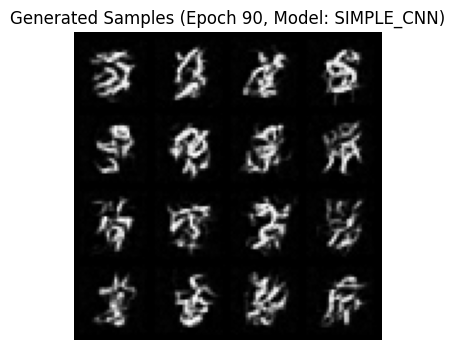

Epoch 91/100: 100%|██████████| 59/59 [00:06<00:00,  9.35it/s, batch_loss=34.3985]

Epoch [91/100] - Avg Loss: 34.7996



Epoch 92/100: 100%|██████████| 59/59 [00:06<00:00,  9.11it/s, batch_loss=35.4353]

Epoch [92/100] - Avg Loss: 34.7421



Epoch 93/100: 100%|██████████| 59/59 [00:06<00:00,  9.75it/s, batch_loss=34.7786]

Epoch [93/100] - Avg Loss: 34.6531



Epoch 94/100: 100%|██████████| 59/59 [00:06<00:00,  9.73it/s, batch_loss=34.1604]

Epoch [94/100] - Avg Loss: 34.7972



Epoch 95/100: 100%|██████████| 59/59 [00:06<00:00,  9.64it/s, batch_loss=34.8167]

Epoch [95/100] - Avg Loss: 34.6178



Epoch 96/100: 100%|██████████| 59/59 [00:06<00:00,  9.64it/s, batch_loss=34.0349]

Epoch [96/100] - Avg Loss: 34.6790



Epoch 97/100: 100%|██████████| 59/59 [00:06<00:00,  9.32it/s, batch_loss=35.3349]

Epoch [97/100] - Avg Loss: 34.7666



Epoch 98/100: 100%|██████████| 59/59 [00:06<00:00,  9.61it/s, batch_loss=34.6808]

Epoch [98/100] - Avg Loss: 34.6964



Epoch 99/100: 100%|██████████| 59/59 [00:06<00:00,  9.83it/s, batch_loss=34.2897]

Epoch [99/100] - Avg Loss: 34.6381



Epoch 100/100: 100%|██████████| 59/59 [00:05<00:00,  9.88it/s, batch_loss=35.1128]

Epoch [100/100] - Avg Loss: 34.5719


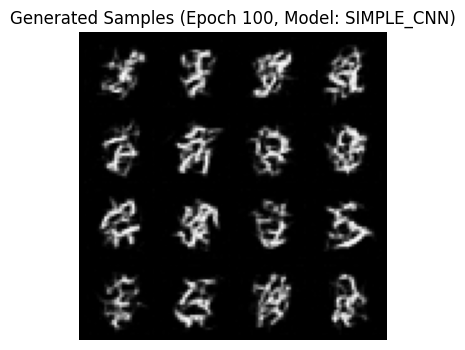

In [2]:
print("\n\n--- Training SimpleCNN Model ---")
# Example 2: Run with the SimpleCNN model
run_noise_predictor(
    model_type="simple_cnn", # Specify SimpleCNN
    alpha=0.7,
    epochs=100, # SimpleCNN might train faster or need fewer epochs
    batch_size=1024,
    lr=1e-3,   # SimpleCNN might tolerate a higher LR
    show_every=10, # Show every 5 epochs for SimpleCNN
    simple_cnn_hidden_dims=(64, 128, 64), # Configure SimpleCNN architecture
    log_freq=100,
    n_samples=16,
    # Unet specific parameters are ignored when model_type="simple_cnn"
)                

--- Training UNET Model ---
Using device: cuda
Selected model type: unet
Estimating x1 statistics...


Finished estimating x1 statistics.
Trainable Parameters (UNET): 1,721,409


Epoch 1/100: 100%|██████████| 59/59 [00:23<00:00,  2.52it/s, batch_loss=59.3738]

Epoch [1/100] - Avg Loss: 139.2631



Epoch 2/100: 100%|██████████| 59/59 [00:23<00:00,  2.51it/s, batch_loss=46.9970]

Epoch [2/100] - Avg Loss: 50.6855



Epoch 3/100: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s, batch_loss=41.5394]

Epoch [3/100] - Avg Loss: 43.3259



Epoch 4/100: 100%|██████████| 59/59 [00:22<00:00,  2.59it/s, batch_loss=37.7427]

Epoch [4/100] - Avg Loss: 39.3631



Epoch 5/100: 100%|██████████| 59/59 [00:23<00:00,  2.46it/s, batch_loss=35.9090]

Epoch [5/100] - Avg Loss: 36.8665



Epoch 6/100: 100%|██████████| 59/59 [00:23<00:00,  2.53it/s, batch_loss=35.3033]

Epoch [6/100] - Avg Loss: 35.3881



Epoch 7/100: 100%|██████████| 59/59 [00:23<00:00,  2.53it/s, batch_loss=33.1102]

Epoch [7/100] - Avg Loss: 34.2196



Epoch 8/100: 100%|██████████| 59/59 [00:23<00:00,  2.48it/s, batch_loss=33.4001]

Epoch [8/100] - Avg Loss: 33.3464



Epoch 9/100: 100%|██████████| 59/59 [00:22<00:00,  2.57it/s, batch_loss=35.1141]

Epoch [9/100] - Avg Loss: 37.4595



Epoch 10/100: 100%|██████████| 59/59 [00:23<00:00,  2.54it/s, batch_loss=32.7011]

Epoch [10/100] - Avg Loss: 33.4355


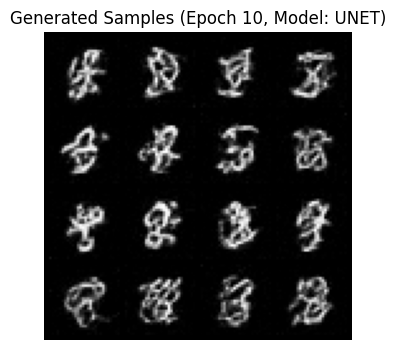

Epoch 11/100: 100%|██████████| 59/59 [00:22<00:00,  2.57it/s, batch_loss=32.5876]

Epoch [11/100] - Avg Loss: 32.3078



Epoch 12/100: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s, batch_loss=31.0353]

Epoch [12/100] - Avg Loss: 31.8199



Epoch 13/100: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s, batch_loss=31.3729]

Epoch [13/100] - Avg Loss: 31.4457



Epoch 14/100: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s, batch_loss=31.1538]

Epoch [14/100] - Avg Loss: 31.2457



Epoch 15/100: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s, batch_loss=30.6080]

Epoch [15/100] - Avg Loss: 30.8279



Epoch 16/100: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s, batch_loss=30.6875]

Epoch [16/100] - Avg Loss: 30.5556



Epoch 17/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=30.4579]

Epoch [17/100] - Avg Loss: 30.3156



Epoch 18/100: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s, batch_loss=30.2670]

Epoch [18/100] - Avg Loss: 30.1105



Epoch 19/100: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s, batch_loss=29.6745]

Epoch [19/100] - Avg Loss: 29.9277



Epoch 20/100: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s, batch_loss=29.8960]

Epoch [20/100] - Avg Loss: 29.7631


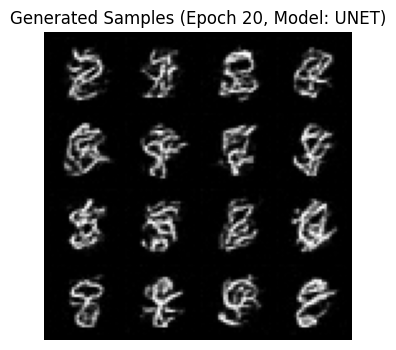

Epoch 21/100: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s, batch_loss=30.1945]

Epoch [21/100] - Avg Loss: 29.6413



Epoch 22/100: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s, batch_loss=29.2063]

Epoch [22/100] - Avg Loss: 29.5425



Epoch 23/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=29.7862]

Epoch [23/100] - Avg Loss: 29.2773



Epoch 24/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=29.5919]

Epoch [24/100] - Avg Loss: 29.3145



Epoch 25/100: 100%|██████████| 59/59 [00:26<00:00,  2.23it/s, batch_loss=29.5015]

Epoch [25/100] - Avg Loss: 29.1504



Epoch 26/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=29.4961]

Epoch [26/100] - Avg Loss: 29.1153



Epoch 27/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=29.4692]

Epoch [27/100] - Avg Loss: 29.0700



Epoch 28/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=28.8313]

Epoch [28/100] - Avg Loss: 28.9351



Epoch 29/100: 100%|██████████| 59/59 [00:26<00:00,  2.27it/s, batch_loss=29.2738]

Epoch [29/100] - Avg Loss: 28.8086



Epoch 30/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=29.0582]

Epoch [30/100] - Avg Loss: 28.7050


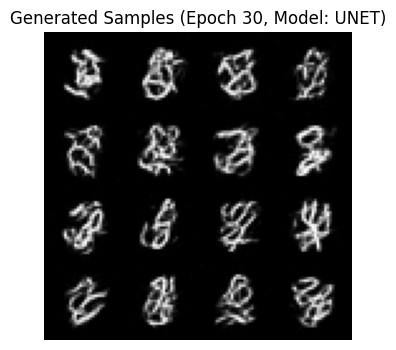

Epoch 31/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.9998]

Epoch [31/100] - Avg Loss: 28.6481



Epoch 32/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=28.7114]

Epoch [32/100] - Avg Loss: 28.6727



Epoch 33/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=29.0755]

Epoch [33/100] - Avg Loss: 28.5803



Epoch 34/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.7955]

Epoch [34/100] - Avg Loss: 28.5453



Epoch 35/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=28.7765]

Epoch [35/100] - Avg Loss: 28.4519



Epoch 36/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.4684]

Epoch [36/100] - Avg Loss: 28.4709



Epoch 37/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=28.5114]

Epoch [37/100] - Avg Loss: 28.3326



Epoch 38/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.4394]

Epoch [38/100] - Avg Loss: 28.2973



Epoch 39/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=28.7009]

Epoch [39/100] - Avg Loss: 28.2878



Epoch 40/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.6848]

Epoch [40/100] - Avg Loss: 28.2585


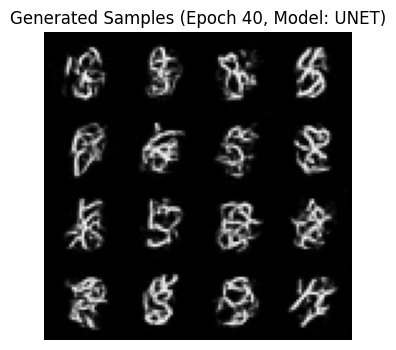

Epoch 41/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.6353]

Epoch [41/100] - Avg Loss: 28.2362



Epoch 42/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=29.0592]

Epoch [42/100] - Avg Loss: 28.1858



Epoch 43/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=28.7772]

Epoch [43/100] - Avg Loss: 28.2490



Epoch 44/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=27.5188]

Epoch [44/100] - Avg Loss: 28.1199



Epoch 45/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=28.3252]

Epoch [45/100] - Avg Loss: 28.1282



Epoch 46/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=27.8778]

Epoch [46/100] - Avg Loss: 28.0332



Epoch 47/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.4206]

Epoch [47/100] - Avg Loss: 27.9911



Epoch 48/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=27.3742]

Epoch [48/100] - Avg Loss: 27.9940



Epoch 49/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=27.5092]

Epoch [49/100] - Avg Loss: 27.9687



Epoch 50/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=28.0755]

Epoch [50/100] - Avg Loss: 27.8989


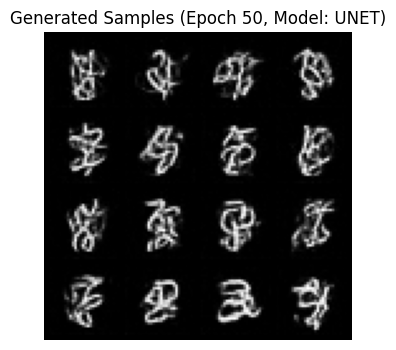

Epoch 51/100: 100%|██████████| 59/59 [00:26<00:00,  2.19it/s, batch_loss=27.9200]

Epoch [51/100] - Avg Loss: 27.8812



Epoch 52/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.2610]

Epoch [52/100] - Avg Loss: 27.9118



Epoch 53/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=27.6618]

Epoch [53/100] - Avg Loss: 27.8083



Epoch 54/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.0334]

Epoch [54/100] - Avg Loss: 27.7855



Epoch 55/100: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s, batch_loss=28.0563]

Epoch [55/100] - Avg Loss: 27.7090



Epoch 56/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.9930]

Epoch [56/100] - Avg Loss: 27.7482



Epoch 57/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=27.6131]

Epoch [57/100] - Avg Loss: 27.7790



Epoch 58/100: 100%|██████████| 59/59 [00:26<00:00,  2.27it/s, batch_loss=27.5501]

Epoch [58/100] - Avg Loss: 27.7523



Epoch 59/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=28.0354]

Epoch [59/100] - Avg Loss: 27.6762



Epoch 60/100: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s, batch_loss=28.1094]

Epoch [60/100] - Avg Loss: 27.5935


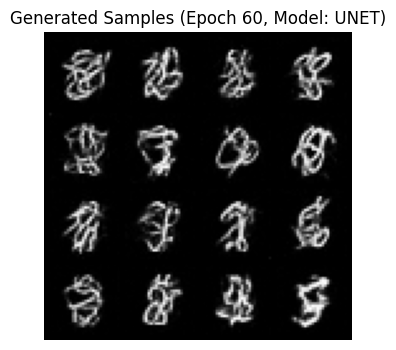

Epoch 61/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=27.5513]

Epoch [61/100] - Avg Loss: 27.6722



Epoch 62/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.7954]

Epoch [62/100] - Avg Loss: 27.6478



Epoch 63/100: 100%|██████████| 59/59 [00:27<00:00,  2.18it/s, batch_loss=28.1724]

Epoch [63/100] - Avg Loss: 27.7110



Epoch 64/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.3424]

Epoch [64/100] - Avg Loss: 27.5725



Epoch 65/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=27.6741]

Epoch [65/100] - Avg Loss: 27.5362



Epoch 66/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=26.8091]

Epoch [66/100] - Avg Loss: 27.5708



Epoch 67/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=27.5394]

Epoch [67/100] - Avg Loss: 27.4665



Epoch 68/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=27.5108]

Epoch [68/100] - Avg Loss: 27.5111



Epoch 69/100: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s, batch_loss=27.4077]

Epoch [69/100] - Avg Loss: 27.5018



Epoch 70/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.6091]

Epoch [70/100] - Avg Loss: 27.5418


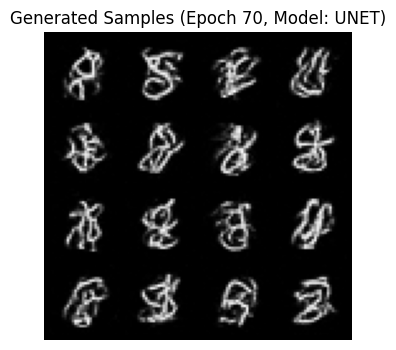

Epoch 71/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.4531]

Epoch [71/100] - Avg Loss: 27.4218



Epoch 72/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=28.0082]

Epoch [72/100] - Avg Loss: 27.3593



Epoch 73/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=26.8373]

Epoch [73/100] - Avg Loss: 27.3845



Epoch 74/100: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s, batch_loss=27.3504]

Epoch [74/100] - Avg Loss: 27.4738



Epoch 75/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=27.0908]

Epoch [75/100] - Avg Loss: 27.4128



Epoch 76/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=27.5166]

Epoch [76/100] - Avg Loss: 27.3999



Epoch 77/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=27.2530]

Epoch [77/100] - Avg Loss: 27.3862



Epoch 78/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.3800]

Epoch [78/100] - Avg Loss: 27.3519



Epoch 79/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=27.2796]

Epoch [79/100] - Avg Loss: 27.3035



Epoch 80/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.8364]

Epoch [80/100] - Avg Loss: 27.3009


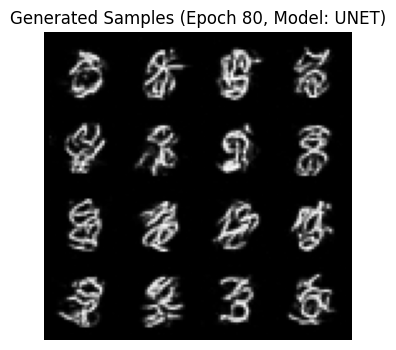

Epoch 81/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=27.1624]

Epoch [81/100] - Avg Loss: 27.3432



Epoch 82/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=28.4243]

Epoch [82/100] - Avg Loss: 27.2650



Epoch 83/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=27.2438]

Epoch [83/100] - Avg Loss: 27.2620



Epoch 84/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.3742]

Epoch [84/100] - Avg Loss: 27.1844



Epoch 85/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.1591]

Epoch [85/100] - Avg Loss: 27.1846



Epoch 86/100: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s, batch_loss=26.7882]

Epoch [86/100] - Avg Loss: 27.2019



Epoch 87/100: 100%|██████████| 59/59 [00:26<00:00,  2.23it/s, batch_loss=26.9874]

Epoch [87/100] - Avg Loss: 27.1736



Epoch 88/100: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s, batch_loss=27.1596]

Epoch [88/100] - Avg Loss: 27.1725



Epoch 89/100: 100%|██████████| 59/59 [00:26<00:00,  2.21it/s, batch_loss=28.0887]

Epoch [89/100] - Avg Loss: 27.1728



Epoch 90/100: 100%|██████████| 59/59 [00:26<00:00,  2.24it/s, batch_loss=27.0728]

Epoch [90/100] - Avg Loss: 27.2115


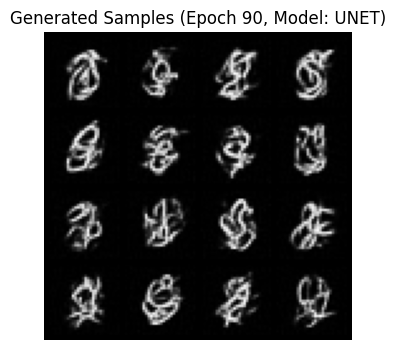

Epoch 91/100: 100%|██████████| 59/59 [00:26<00:00,  2.21it/s, batch_loss=27.4707]

Epoch [91/100] - Avg Loss: 27.1846



Epoch 92/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=26.5366]

Epoch [92/100] - Avg Loss: 27.0592



Epoch 93/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=26.9472]

Epoch [93/100] - Avg Loss: 27.1243



Epoch 94/100: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s, batch_loss=27.5242]

Epoch [94/100] - Avg Loss: 27.0448



Epoch 95/100: 100%|██████████| 59/59 [00:26<00:00,  2.23it/s, batch_loss=27.0852]

Epoch [95/100] - Avg Loss: 27.1106



Epoch 96/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=26.6335]

Epoch [96/100] - Avg Loss: 27.1423



Epoch 97/100: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s, batch_loss=27.0869]

Epoch [97/100] - Avg Loss: 27.0539



Epoch 98/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=27.0835]

Epoch [98/100] - Avg Loss: 27.0191



Epoch 99/100: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s, batch_loss=28.1703]

Epoch [99/100] - Avg Loss: 27.0705



Epoch 100/100: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s, batch_loss=26.7855]

Epoch [100/100] - Avg Loss: 27.0288


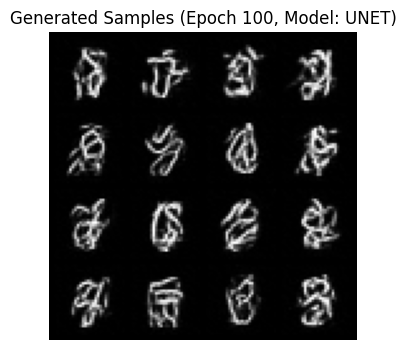

In [3]:
print("--- Training UNET Model ---")
run_noise_predictor(
    model_type="unet", # Specify Unet
    alpha=0.7,
    epochs=100, 
    batch_size=1024,
    lr=1e-3,    
    show_every=10, # Show every 10 epochs for Unet
    base_dim=32,
    dim_mults=(1, 2, 4),
    num_res_blocks_encoder=2,
    num_res_blocks_decoder=2,
    num_res_blocks_mid=1,
    log_freq=100,
    n_samples=16,
)

As you can see, it kinda learns how to generate the digits, but not really. One step diffusion is not easy. Even with a better neural network (U-Net vs. Conv) that is often used in diffusion, we are not getting better results.

That's why multi step diffusion models are more common. Also the problem is that corrupting $x_{0}$ with noise to make $x_{1}$, won't make it a normal Gaussian, unless $\alpha$ is 0. But if it's set to 0, then the decoder can't learn anything since there is no signal in $x_{1}$, but only noise.